In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Desativa notação científica para visualização
pd.set_option('display.float_format', '{:.6f}'.format)
np.set_printoptions(suppress=True, precision=6)

# Pega a pasta atual do script
base_dir = Path().resolve().parents[2]

data_dir = base_dir / "datalake" / "data-for-model"

df_train = pd.read_parquet(data_dir / "train" / "train_sleep_cassette.parquet", engine="fastparquet")
df_val = pd.read_parquet(data_dir / "val" / "val_sleep_cassette.parquet", engine="fastparquet")
df_test = pd.read_parquet(data_dir / "test" / "test_sleep_cassette.parquet", engine="fastparquet")

In [2]:

print("Train shape:", df_train.shape)
print("Val shape:", df_val.shape)
print("Test shape:", df_test.shape)

print("\nDistribuição da variável alvo (stage):")
print(df_train["stage"].value_counts(normalize=True))

print("\nTipos de dados:")
print(df_train.dtypes)

print("\nValores nulos:")
print(df_train.isnull().sum())


Train shape: (112753, 65)
Val shape: (42381, 65)
Test shape: (35878, 65)

Distribuição da variável alvo (stage):
stage
N2    0.357809
W     0.309837
REM   0.133566
N1    0.123119
N3    0.075670
Name: proportion, dtype: float64

Tipos de dados:
subject_id                                       object
night_id                                         object
epoch_idx                                         int64
stage                                          category
age                                               int64
                                                 ...   
EEG_Pz_Oz_delta_relpow_256_roll_mean_15         float64
EEG_Pz_Oz_spec_entropy_256_roll_mean_15         float64
EEG_Fpz_Cz_aperiodic_slope_256_roll_mean_15     float64
EOG_rms_roll_max_10                             float64
EMG_submental_p90_1hz_roll_max_10               float64
Length: 65, dtype: object

Valores nulos:
subject_id                                     0
night_id                                       0


In [3]:

from sklearn.preprocessing import LabelEncoder, StandardScaler

drop_cols = ["stage", "subject_id", "night_id", "sex", "age"]
X_train = df_train.drop(columns=drop_cols, errors="ignore")
y_train = df_train["stage"]

X_val = df_val.drop(columns=drop_cols, errors="ignore")
y_val = df_val["stage"]

X_test = df_test.drop(columns=drop_cols, errors="ignore")
y_test = df_test["stage"]


In [4]:

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

print("Classes codificadas:", le.classes_)
print("Exemplo de y_train codificado:", y_train_enc[:5])


Classes codificadas: ['N1' 'N2' 'N3' 'REM' 'W']
Exemplo de y_train codificado: [4 4 4 4 4]


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Verificação da normalização
print("Shape das features normalizadas:", X_train_scaled.shape)
print("Resumo estatístico das features normalizadas:")
print(pd.DataFrame(X_train_scaled).describe())


Shape das features normalizadas: (112753, 60)
Resumo estatístico das features normalizadas:
                 0             1             2             3             4   \
count 112753.000000 112753.000000 112753.000000 112753.000000 112753.000000   
mean      -0.000000      0.000000     -0.000000     -0.000000     -0.000000   
std        1.000004      1.000004      1.000004      1.000004      1.000004   
min       -3.028070     -1.393799     -0.735680     -2.905600     -4.226504   
25%       -0.685275     -0.805189     -0.602272     -0.613331     -0.463883   
50%       -0.000664     -0.113914     -0.424203      0.171273      0.230302   
75%        0.672834      0.593330      0.133291      0.761107      0.733994   
max        3.031188      3.477062      6.179614      1.824621      1.517857   

                 5             6             7             8             9   \
count 112753.000000 112753.000000 112753.000000 112753.000000 112753.000000   
mean      -0.000000     -0.000000     

In [6]:
from sklearn.impute import SimpleImputer

# Imputação para substituir NaNs por média
imputer = SimpleImputer(strategy="mean")
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_val_scaled = imputer.transform(X_val_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

In [7]:
model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train_scaled, y_train_enc)



/home/leona/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [8]:

y_val_pred = model.predict(X_val_scaled)

print("Avaliação no conjunto de validação:")
print(classification_report(y_val_enc, y_val_pred, target_names=le.classes_))
print("Matriz de confusão (validação):")
print(confusion_matrix(y_val_enc, y_val_pred))


Avaliação no conjunto de validação:
              precision    recall  f1-score   support

          N1       0.32      0.53      0.40      4215
          N2       0.89      0.60      0.72     15066
          N3       0.50      0.85      0.63      2524
         REM       0.60      0.81      0.69      5456
           W       0.93      0.84      0.88     15120

    accuracy                           0.72     42381
   macro avg       0.65      0.73      0.66     42381
weighted avg       0.79      0.72      0.74     42381

Matriz de confusão (validação):
[[ 2228   506    93   805   583]
 [ 2154  9037  1931  1733   211]
 [   71   294  2135     9    15]
 [  655   204    36  4431   130]
 [ 1778   152    61   403 12726]]


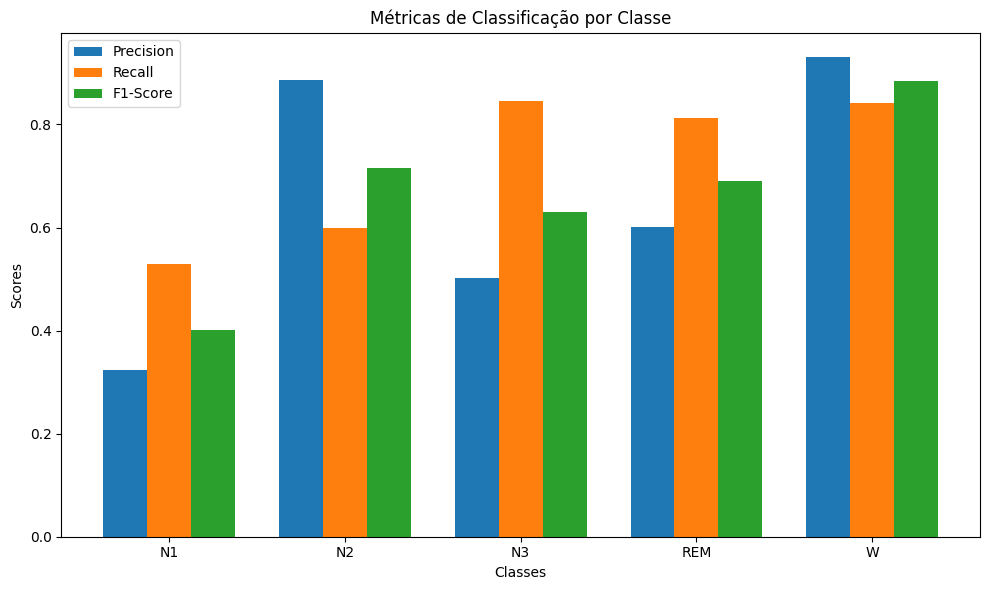

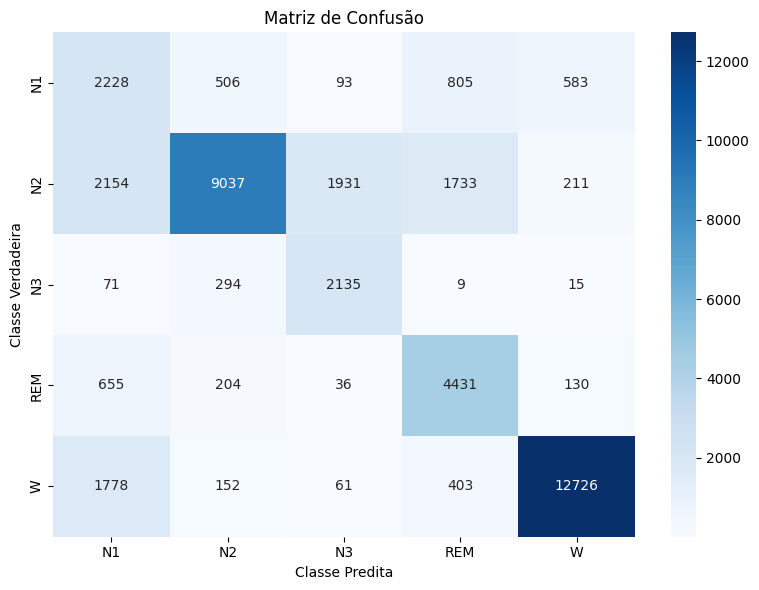

In [9]:
# Labels das classes
class_labels = le.classes_

# Matriz de confusão
conf_matrix = confusion_matrix(y_val_enc, y_val_pred)

# Relatório de classificação
report = classification_report(y_val_enc, y_val_pred, target_names=class_labels, output_dict=True)

# Extrai métricas por classe
precision = [report[label]["precision"] for label in class_labels]
recall = [report[label]["recall"] for label in class_labels]
f1_score = [report[label]["f1-score"] for label in class_labels]

# Gráfico de métricas
x = np.arange(len(class_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Métricas de Classificação por Classe')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()
plt.tight_layout()
plt.savefig("classification_metrics.png")
plt.show()

# Gráfico da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

In [10]:
y_test_pred = model.predict(X_test_scaled)

print("Avaliação no conjunto de teste (baseline):")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))


Avaliação no conjunto de teste (baseline):
              precision    recall  f1-score   support

          N1       0.32      0.50      0.39      3425
          N2       0.86      0.69      0.77     13722
          N3       0.52      0.85      0.64      1983
         REM       0.64      0.74      0.68      5319
           W       0.93      0.81      0.87     11429

    accuracy                           0.73     35878
   macro avg       0.65      0.72      0.67     35878
weighted avg       0.78      0.73      0.75     35878



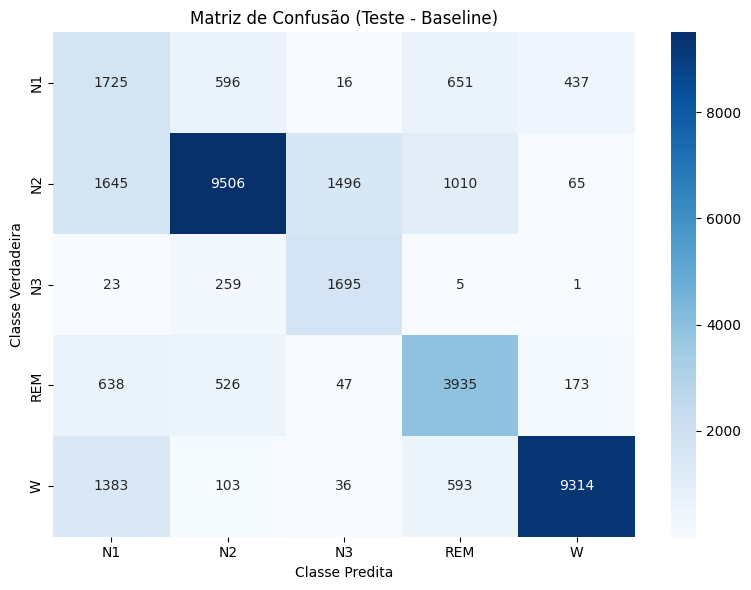

In [11]:
conf_matrix_test = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão (Teste - Baseline)')
plt.tight_layout()
plt.show()


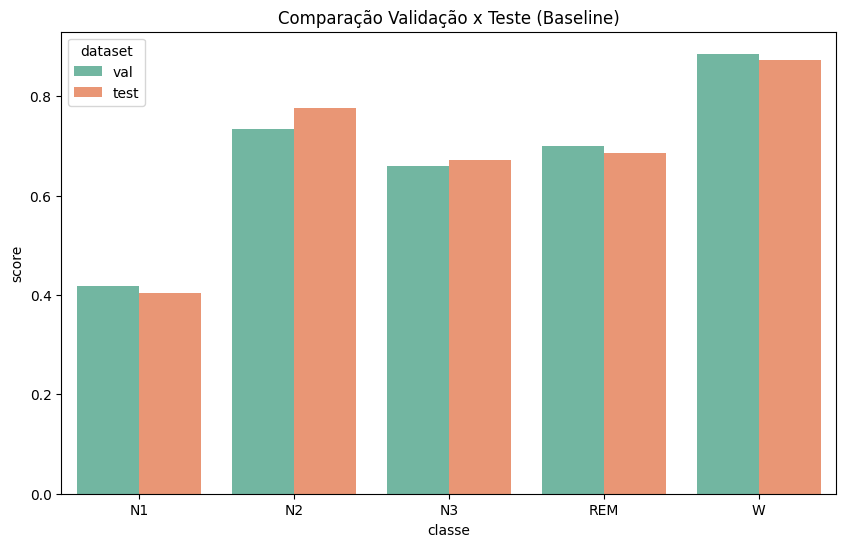

In [12]:
from sklearn.metrics import classification_report

# Relatórios
report_val = classification_report(y_val_enc, y_val_pred, target_names=le.classes_, output_dict=True)
report_test = classification_report(y_test_enc, y_test_pred, target_names=le.classes_, output_dict=True)

# Extrai métricas
metrics = ["precision", "recall", "f1-score"]
rows = []

for label in le.classes_:
    for metric in metrics:
        rows.append({
            "classe": label,
            "métrica": metric,
            "val": report_val[label][metric],
            "test": report_test[label][metric]
        })

df_metrics = pd.DataFrame(rows)

# Plot
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df_metrics.melt(id_vars=["classe", "métrica"], value_vars=["val","test"], 
                                 var_name="dataset", value_name="score"),
            x="classe", y="score", hue="dataset", palette="Set2", errorbar=None, ax=ax)

ax.set_title("Comparação Validação x Teste (Baseline)")
plt.show()

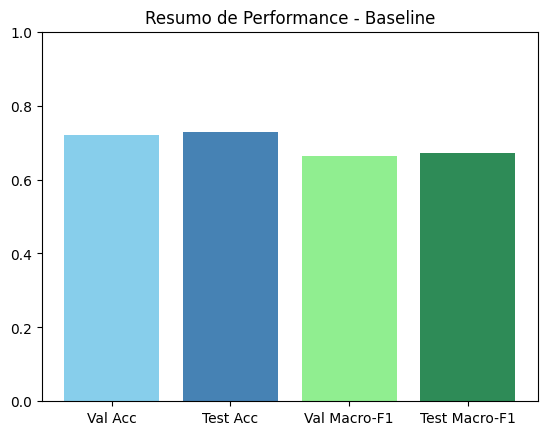

In [13]:
acc_val = report_val["accuracy"]
acc_test = report_test["accuracy"]
f1_val = report_val["macro avg"]["f1-score"]
f1_test = report_test["macro avg"]["f1-score"]

plt.bar(["Val Acc","Test Acc","Val Macro-F1","Test Macro-F1"], 
        [acc_val, acc_test, f1_val, f1_test], color=["skyblue","steelblue","lightgreen","seagreen"])
plt.title("Resumo de Performance - Baseline")
plt.ylim(0,1)
plt.show()
